In [1]:
#|default_exp train

In [2]:
# !pip install -U transformers nbdev fastcore accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [4]:
#|export
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
from types import SimpleNamespace
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from utils import (
    plot_density, 
    pil_add_text, 
    latent_to_PIL, 
    make_grid, 
    fmnist_labels, 
    encode_prompt, 
    dcae_scalingf, 
    pil_clipscore, 
    cifar10_labels, 
    free_memory, 
    mnist_labels
)

seed = 42
set_seed(seed)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
#|export
def load_models(text_encoder, transformer_config, ae, dtype, device):
    transformer = SanaTransformer2DModel.from_config(transformer_config).to(device).to(dtype)
    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def load_data(repo_name, split_train="train", split_test="test", col_latent = "latent", col_label = "label"):
    print(f"loading dataset {repo_name}")
    
    ds = load_dataset(repo_name)
    for split in ds: 
        if not split in [split_train, split_test]: 
            del ds[split]
    latent_shape = torch.Tensor(ds[split_train][0][col_latent]).shape
    features = ds[split_train].features

    assert len(latent_shape)==4
    assert col_latent in features and col_label in features
    assert ds[split_train].features==ds[split_test].features

    if debug:
        for i, split in enumerate([split_train, split_test]): 
            print(f" split #{i} {split}: {len(ds[split])} samples, features: {[k for k in ds[split].features]}")
        print(f" latent shape {latent_shape}")

    return ds, latent_shape
    
def collate_(items, labels_encoded, col_latent = "latent", col_label = "label"):
    assert col_latent in items[0] and col_label in items[0]
    labels = [i[col_label] for i in items]
    latents = torch.cat([torch.Tensor(i[col_latent]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

def get_dataloader(dataset, batch_size, collate_fn):
    if ddp:
        sampler = DistributedSampler(dataset, shuffle = True, seed = seed)
    else:
        sampler = RandomSampler(dataset, generator = torch.manual_seed(seed))
        
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        sampler = sampler,
        collate_fn = collate_fn
    )
    
    if debug:
        print("dataset size", len(dataset))
        for i, col in enumerate(next(iter(dataloader))):
            coltype = type(col)
            collength = len(col) if coltype==list else col.shape
            print(f" col {i} {coltype.__name__} {collength}")
    return dataloader, sampler
    
def get_timesteps(num_steps):
    dt = 1.0 / num_steps
    timesteps = [int(i/num_steps*1000) for i in range(num_steps, 0, -1)]
    return dt, timesteps

def get_sigmas(num_samples, dist="normal"):
    if dist == "normal":
        sigmas = torch.randn((num_samples,)).sigmoid()
    elif dist == "uniform":
        sigmas = torch.rand((num_samples,))
    elif dist == "beta":
        beta_dist = torch.distributions.beta.Beta(torch.tensor(1), torch.tensor(2.5))
        sigmas = beta_dist.sample([num_samples])
    else:
        assert True==False, f"unknown distribution {dist}"
    return sigmas

def add_random_noise(latents, dist, timesteps=1000):
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    sigmas = get_sigmas(bs, dist=dist).to(latents.device)  # floats 0-1 of dist specified in train_config
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), noise, timesteps

def generate(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, latent_seed=None):
    assert latent_dim is not None
    dt, timesteps = get_timesteps(num_steps)
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dtype).to(device)
    for t in timesteps:
        t = torch.Tensor([t]).to(dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(latent, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latent = latent - dt * noise_pred

    return latent_to_PIL(latent / dcae_scalingf, dcae)

def eval_loss(dataloader_eval, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist=train_config.sigma_sampling)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
    return sum(losses)/len(losses)

In [6]:
#|export
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
debug = True
ddp = True

model_config = SimpleNamespace(
    text_encoder = "answerdotai/ModernBERT-base",
    transformer_config = "transformer_Sana-DiT-S-MBERT.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
)

data_config = SimpleNamespace(
    dataset = "g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0",
    labels_dict = fmnist_labels,
    col_label = "label",
    col_latent = "latent",
    split_train = "train",
    split_eval = "test",
)

train_config = SimpleNamespace(
    lr = 5e-4,
    bs = 1024,
    epochs = 20,
    steps_log = 10,
    steps_eval = 300,
    eval_prompts = [data_config.labels_dict[k] for k in data_config.labels_dict],
    eval_seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    eval_timesteps = 100, # number of timesteps for generating eval images
    timesteps_training = 1000,
    sigma_sampling = "normal",  # beta uniform normal
    log_wandb = True,
    wandb_project = "Hana",
    wandb_run = "Sana-DiT-S-{size:.2f}M_{ds}_LR-{lr}_BS-{bs}_{ts_sampling}-TS-{ts}_{device}",
)

In [7]:
# DON'T EXPORT
ddp = False

In [8]:
#|export
if ddp:
    dist.init_process_group(backend='nccl')
    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    bs_new = round(train_config.bs / world_size / 8) * 8
    if is_master:
        print(f"DDP: global batch size {train_config.bs} with world of {world_size} => setting per_device_bs to {bs_new}")
    train_config.bs = bs_new
    debug = debug and is_master
else:
    is_master = True
    world_size = 1
    local_rank = 0

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = model_config.text_encoder,
    transformer_config = model_config.transformer_config,
    ae = model_config.ae,
    dtype = dtype,
    device = device
)
if ddp:
	transformer = DistributedDataParallel(transformer, device_ids=[local_rank])
    
ds, latent_shape = load_data(data_config.dataset)

collate_fn = partial(
    collate_, 
    labels_encoded = {
        k: encode_prompt(data_config.labels_dict[k], tokenizer, text_encoder) 
        for k in data_config.labels_dict
    }
)
dataloader_train, dataloader_train_sampler = get_dataloader(ds[data_config.split_train], train_config.bs, collate_fn)
dataloader_eval, _ =  get_dataloader(ds[data_config.split_eval], train_config.bs, collate_fn)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=train_config.lr)

wandb_run = train_config.wandb_run.format(
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    ts=train_config.timesteps_training,
    ts_sampling=train_config.sigma_sampling.upper(),
    device=device,
    ds=data_config.dataset.split("/")[1].split("-")[0]
)

steps_epoch = len(dataloader_train)
if is_master: 
    print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Transformer parameters: 17.78M
DCAE parameters: 312.25M
loading dataset g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0
 split #0 train: 60000 samples, features: ['label', 'latent']
 split #1 test: 10000 samples, features: ['label', 'latent']
 latent shape torch.Size([1, 32, 2, 2])
dataset size 60000
 col 0 list 1024
 col 1 Tensor torch.Size([1024, 32, 2, 2])
 col 2 Tensor torch.Size([1024, 300, 768])
 col 3 Tensor torch.Size([1024, 300])
dataset size 10000
 col 0 list 1024
 col 1 Tensor torch.Size([1024, 32, 2, 2])
 col 2 Tensor torch.Size([1024, 300, 768])
 col 3 Tensor torch.Size([1024, 300])
steps per epoch: 59


Sigma distribution:


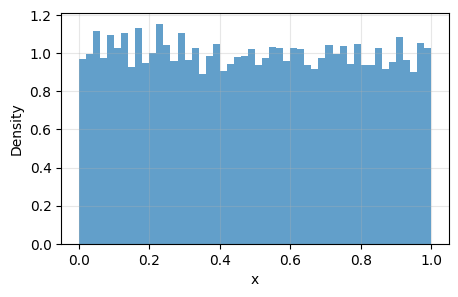

Testing noising:


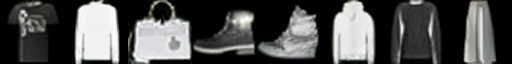

timesteps rounded [273, 204, 348, 429, 252, 948, 135, 550]


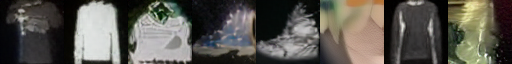

Eval prompts:
[(0, 'T-shirt/top'), (1, 'Trouser'), (2, 'Pullover'), (3, 'Dress'), (4, 'Coat'), (5, 'Sandal'), (6, 'Shirt'), (7, 'Sneaker'), (8, 'Bag'), (9, 'Ankle boot')]
Inspecting first batch


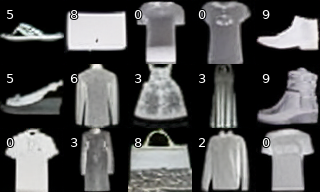

Testing generate


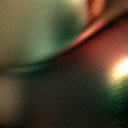

Testing eval loss


eval_loss: 0it [00:00, ?it/s]


3.046875
Testing eval images and clip score


eval_images: 100%|██████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]


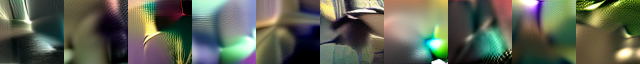

22.280364990234375


In [9]:
# DONT EXPORT
if is_master: 
    print("Sigma distribution:")
    sigmas = get_sigmas(10_000, train_config.sigma_sampling)
    plot_density(sigmas)

    print("Testing noising:")
    def test_noising():
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
        latent=latents[0:8,:] * dcae_scalingf
        display(make_grid(latent_to_PIL(latent / dcae_scalingf,dcae)))
        
        latent_noisy, noise, timesteps = add_random_noise(latent, dist=train_config.sigma_sampling)
        
        print("timesteps rounded", list(map(round, timesteps.tolist())))
        display(make_grid(latent_to_PIL(latent_noisy / dcae_scalingf,dcae)))
    test_noising()

    print("Eval prompts:")
    print(list(enumerate(train_config.eval_prompts)))
    
    print("Inspecting first batch")
    def show_first_batch(dataloader):
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
        images = [pil_add_text(latent_to_PIL(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
        display(make_grid(images[:15], 3, 5))
    show_first_batch(dataloader_train)
    
    print("Testing generate")
    display(generate("horse", tokenizer, text_encoder, num_steps=10, latent_dim=latent_shape).resize((128,128)))
    
    print("Testing eval loss")
    print(eval_loss(dataloader_eval, testing=True))
    
    print("Testing eval images and clip score")
    images = [
        generate(p, tokenizer, text_encoder, latent_dim=latent_shape, num_steps=10) 
        for p in tqdm(train_config.eval_prompts, "eval_images")
    ]
    display(make_grid(images))
    print(pil_clipscore(images, train_config.eval_prompts))

# Train

In [10]:
import nbdev; nbdev.export.nb_export(__session__)

In [11]:
#|export

free_memory()

if is_master and train_config.log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(
        project=train_config.wandb_project, 
        name=wandb_run
    ).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()
free_memory()

for epoch in range(train_config.epochs):
    if ddp:
        dataloader_train_sampler.set_epoch(epoch)
    
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader_train:
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist = train_config.sigma_sampling)
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(noise_pred, noise - latents)
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if is_master and step>0 and step % train_config.steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
            sample_count = step * train_config.bs * world_size
            sample_tp = train_config.bs * train_config.steps_log * world_size / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.2f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if train_config.log_wandb: 
                wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": sample_count, "epoch": step / steps_epoch})
            last_step_time = time.time()

        if is_master and step>0 and step % train_config.steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)

            # try different seeds for generating eval images
            images_eval = [
                generate(p, tokenizer, text_encoder, num_steps=train_config.eval_timesteps, latent_dim=latent_shape, latent_seed=seed) 
                for seed in tqdm(train_config.eval_seeds, "eval_images")
                for p in train_config.eval_prompts
            ]
            clipscore = pil_clipscore(images_eval, train_config.eval_prompts * len(train_config.eval_seeds))
            # add labels before logging the images
            images_eval = make_grid([
                pil_add_text(img, train_config.eval_prompts[i % len(train_config.eval_prompts)]) 
                for i, img in enumerate(images_eval)
            ], rows=len(train_config.eval_seeds), cols=len(train_config.eval_prompts))
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if train_config.log_wandb: 
                wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": step * train_config.bs, "epoch": step / steps_epoch})
            transformer.train()        

        step += 1

if ddp:
    dist.destroy_process_group()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 10, epoch: 0.17, train loss: 1.8906, grad_norm: 1.27, 612.77ms/step, 1671.10samples/sec
step 20, epoch: 0.34, train loss: 1.5312, grad_norm: 0.59, 467.55ms/step, 2190.12samples/sec
step 30, epoch: 0.51, train loss: 1.3047, grad_norm: 0.56, 465.45ms/step, 2200.00samples/sec
step 40, epoch: 0.68, train loss: 1.1406, grad_norm: 0.64, 428.23ms/step, 2391.23samples/sec
step 50, epoch: 0.85, train loss: 1.0469, grad_norm: 0.69, 462.26ms/step, 2215.20samples/sec
step 60, epoch: 1.02, train loss: 0.9648, grad_norm: 0.69, 451.88ms/step, 2266.06samples/sec
step 70, epoch: 1.19, train loss: 0.9062, grad_norm: 0.53, 461.12ms/step, 2220.70samples/sec
step 80, epoch: 1.36, train loss: 0.8984, grad_norm: 0.48, 460.35ms/step, 2224.37samples/sec
step 90, epoch: 1.53, train loss: 0.8828, grad_norm: 0.52, 458.76ms/step, 2232.09samples/sec
step 100, epoch: 1.69, train loss: 0.8633, grad_norm: 0.46, 459.40ms/step, 2228.97samples/sec
step 110, epoch: 1.86, train loss: 0.8555, grad_norm: 0.42, 457.50ms/

eval_loss: 10it [00:04,  2.45it/s]
eval_images: 100%|████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


step 300, eval loss: 0.7773, clipscore: 25.96
step 310, epoch: 5.25, train loss: 0.7812, grad_norm: 0.37, 6005.85ms/step, 170.50samples/sec
step 320, epoch: 5.42, train loss: 0.7852, grad_norm: 0.34, 463.44ms/step, 2209.57samples/sec
step 330, epoch: 5.59, train loss: 0.7617, grad_norm: 0.38, 464.31ms/step, 2205.40samples/sec
step 340, epoch: 5.76, train loss: 0.7617, grad_norm: 0.38, 465.01ms/step, 2202.08samples/sec
step 350, epoch: 5.93, train loss: 0.7656, grad_norm: 0.35, 463.55ms/step, 2209.05samples/sec
step 360, epoch: 6.10, train loss: 0.7500, grad_norm: 0.33, 452.41ms/step, 2263.45samples/sec
step 370, epoch: 6.27, train loss: 0.7695, grad_norm: 0.31, 463.36ms/step, 2209.96samples/sec
step 380, epoch: 6.44, train loss: 0.7539, grad_norm: 0.31, 461.16ms/step, 2220.48samples/sec
step 390, epoch: 6.61, train loss: 0.7656, grad_norm: 0.34, 458.84ms/step, 2231.73samples/sec
step 400, epoch: 6.78, train loss: 0.7500, grad_norm: 0.32, 457.51ms/step, 2238.20samples/sec
step 410, epoc

eval_loss: 10it [00:04,  2.41it/s]
eval_images: 100%|████████████████████████████████| 5/5 [00:42<00:00,  8.55s/it]


step 600, eval loss: 0.7359, clipscore: 26.01
step 610, epoch: 10.34, train loss: 0.7578, grad_norm: 0.36, 5915.10ms/step, 173.12samples/sec
step 620, epoch: 10.51, train loss: 0.7500, grad_norm: 0.36, 462.88ms/step, 2212.22samples/sec
step 630, epoch: 10.68, train loss: 0.7266, grad_norm: 0.29, 462.52ms/step, 2213.94samples/sec
step 640, epoch: 10.85, train loss: 0.7305, grad_norm: 0.29, 431.17ms/step, 2374.91samples/sec
step 650, epoch: 11.02, train loss: 0.7344, grad_norm: 0.29, 453.37ms/step, 2258.64samples/sec
step 660, epoch: 11.19, train loss: 0.7266, grad_norm: 0.32, 463.76ms/step, 2208.05samples/sec
step 670, epoch: 11.36, train loss: 0.7266, grad_norm: 0.27, 461.85ms/step, 2217.19samples/sec
step 680, epoch: 11.53, train loss: 0.7188, grad_norm: 0.28, 461.59ms/step, 2218.42samples/sec
step 690, epoch: 11.69, train loss: 0.7383, grad_norm: 0.30, 463.02ms/step, 2211.57samples/sec
step 700, epoch: 11.86, train loss: 0.7305, grad_norm: 0.27, 460.59ms/step, 2223.22samples/sec
step

eval_loss: 10it [00:04,  2.41it/s]
eval_images: 100%|████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


step 900, eval loss: 0.7227, clipscore: 26.48
step 910, epoch: 15.42, train loss: 0.7422, grad_norm: 0.32, 5889.63ms/step, 173.86samples/sec
step 920, epoch: 15.59, train loss: 0.7305, grad_norm: 0.25, 468.30ms/step, 2186.65samples/sec
step 930, epoch: 15.76, train loss: 0.7109, grad_norm: 0.28, 469.12ms/step, 2182.83samples/sec
step 940, epoch: 15.93, train loss: 0.7266, grad_norm: 0.30, 430.26ms/step, 2379.96samples/sec
step 950, epoch: 16.10, train loss: 0.7266, grad_norm: 0.27, 455.06ms/step, 2250.26samples/sec
step 960, epoch: 16.27, train loss: 0.7070, grad_norm: 0.25, 463.74ms/step, 2208.14samples/sec
step 970, epoch: 16.44, train loss: 0.7266, grad_norm: 0.25, 463.37ms/step, 2209.88samples/sec
step 980, epoch: 16.61, train loss: 0.7070, grad_norm: 0.26, 463.20ms/step, 2210.70samples/sec
step 990, epoch: 16.78, train loss: 0.7344, grad_norm: 0.29, 462.01ms/step, 2216.39samples/sec
step 1000, epoch: 16.95, train loss: 0.7109, grad_norm: 0.25, 464.31ms/step, 2205.43samples/sec
ste

In [12]:
# if is_master:
#     transformer.push_to_hub(f"g-ronimo/hana-alpha20")